<a href="https://colab.research.google.com/github/stelios191/Image-Classification/blob/main/FashionMNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Classification


In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
from sklearn.metrics import precision_recall_fscore_support
import torch.optim as optim

In [ ]:
train_set = torchvision.datasets.FashionMNIST(root = ".", train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = ".", train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
# Fix the seed to be able to get the same randomness across runs
# and hence reproducible outcomes
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# If you are using CuDNN , otherwise you can just ignore
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False



100%|██████████| 26421880/26421880 [00:01<00:00, 17746134.35it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273550.83it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5001488.53it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26204219.65it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
class ConvNet(nn.Module):
    def __init__(self, activation_fn=nn.ReLU):
        super(ConvNet, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        # Activation Fucntion
        self.act = activation_fn()

    def forward(self, x):
        # Apply first convolution, activation, and pooling
        x = self.act(self.conv1(x))
        x = self.pool(x)
        # Apply second convolution, activation, and pooling
        x = self.act(self.conv2(x))
        x = self.pool(x)
        # Flatten, apply fully connected layers and activations
        x = x.view(-1, 64 * 4 * 4)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        # Apply output layer
        x = self.fc3(x)
        return x
# Function to initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
def train_and_evaluate(net, epochs=30, lr=0.1):
    # Move network to the current device and initialize weights
    net.to(device)
    net.apply(init_weights)
    # Set up SGD optimizer and cross entropy loss function
    optimizer = optim.SGD(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    # Initialize lists
    train_accuracy = []
    test_accuracy = []
    train_losses = []
    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        net.train()
        # Iterate over training data
        for i, data in enumerate(train_loader, 0):
            # Load data and labels, move to current device
            inputs, labels = data[0].to(device), data[1].to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, compute loss, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Update running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        # Calculate and store training loss and accuracy
        train_losses.append(running_loss / len(train_loader))
        train_accuracy.append(correct_train / total_train)
        correct_test = 0
        total_test = 0
        net.eval()
        # Disable gradient calculations
        with torch.no_grad():
            # Iterate over testing data
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        # Store testing accuracy
        test_accuracy.append(correct_test / total_test)
        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs} - Loss: {running_loss / len(train_loader):.4f}, '
              f'Train Accuracy: {correct_train / total_train:.4f}, '
              f'Test Accuracy: {correct_test / total_test:.4f}')

    return train_accuracy, test_accuracy, train_losses


In [ ]:
# Set the device to GPU if available otherwise it will use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Print the selected device
print(device)
net = ConvNet(nn.ReLU)
train_acc_relu, test_acc_relu, train_loss_relu = train_and_evaluate(net)

cuda:0
Epoch 1/30 - Loss: 0.5206, Train Accuracy: 0.8056, Test Accuracy: 0.8623
Epoch 2/30 - Loss: 0.3219, Train Accuracy: 0.8807, Test Accuracy: 0.8787
Epoch 3/30 - Loss: 0.2740, Train Accuracy: 0.8968, Test Accuracy: 0.8969
Epoch 4/30 - Loss: 0.2433, Train Accuracy: 0.9102, Test Accuracy: 0.8953
Epoch 5/30 - Loss: 0.2165, Train Accuracy: 0.9181, Test Accuracy: 0.8999
Epoch 6/30 - Loss: 0.1965, Train Accuracy: 0.9252, Test Accuracy: 0.9066
Epoch 7/30 - Loss: 0.1744, Train Accuracy: 0.9343, Test Accuracy: 0.9049
Epoch 8/30 - Loss: 0.1590, Train Accuracy: 0.9397, Test Accuracy: 0.9076
Epoch 9/30 - Loss: 0.1418, Train Accuracy: 0.9461, Test Accuracy: 0.9043
Epoch 10/30 - Loss: 0.1292, Train Accuracy: 0.9509, Test Accuracy: 0.9034
Epoch 11/30 - Loss: 0.1152, Train Accuracy: 0.9559, Test Accuracy: 0.9137
Epoch 12/30 - Loss: 0.0984, Train Accuracy: 0.9627, Test Accuracy: 0.9121
Epoch 13/30 - Loss: 0.0935, Train Accuracy: 0.9640, Test Accuracy: 0.9088
Epoch 14/30 - Loss: 0.0810, Train Accura

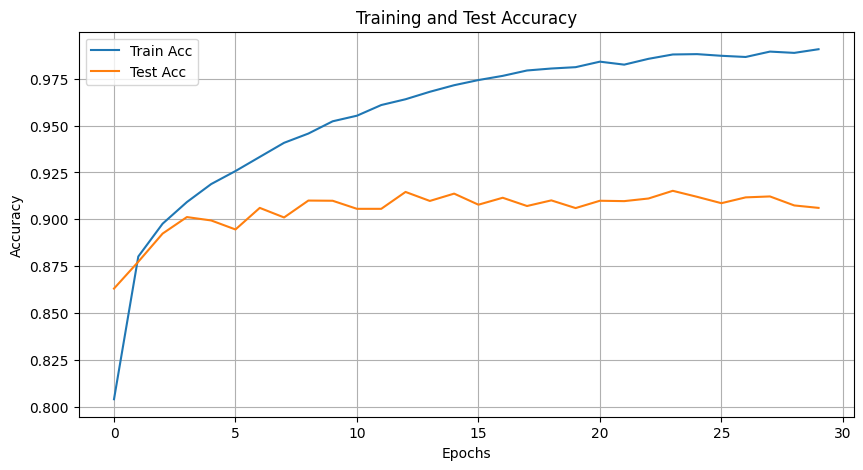

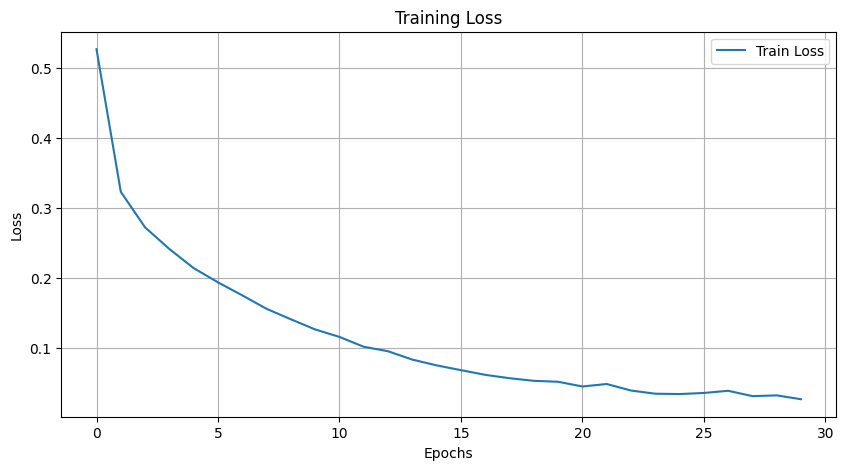

In [ ]:
# Plotting the training and test accuracies
plt.figure(figsize=(10, 5))
plt.title("Training and Test Accuracy")
plt.plot(train_acc_relu, label='Train Acc')
plt.plot(test_acc_relu, label='Test Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.title("Training Loss")
plt.plot(train_loss_relu, label='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# For Tanh Activation
net = ConvNet(nn.Tanh)
print("Tahn Activation:")
train_acc_tanh, test_acc_tanh, train_loss_tanh = train_and_evaluate(net)

# For Sigmoid Activation
net = ConvNet(nn.Sigmoid)
print("Sigmoid Activation:")
train_acc_sigmoid, test_acc_sigmoid, train_loss_sigmoid = train_and_evaluate(net)

# For ELU Activation
net = ConvNet(nn.ELU)
print("ELU Activation:")
train_acc_elu, test_acc_elu, train_loss_elu = train_and_evaluate(net)

Tahn Activation:
Epoch 1/30 - Loss: 0.4652, Train Accuracy: 0.8317, Test Accuracy: 0.8693
Epoch 2/30 - Loss: 0.3190, Train Accuracy: 0.8831, Test Accuracy: 0.8871
Epoch 3/30 - Loss: 0.2693, Train Accuracy: 0.8999, Test Accuracy: 0.8917
Epoch 4/30 - Loss: 0.2329, Train Accuracy: 0.9133, Test Accuracy: 0.8966
Epoch 5/30 - Loss: 0.2074, Train Accuracy: 0.9223, Test Accuracy: 0.9017
Epoch 6/30 - Loss: 0.1799, Train Accuracy: 0.9327, Test Accuracy: 0.9071
Epoch 7/30 - Loss: 0.1570, Train Accuracy: 0.9421, Test Accuracy: 0.9097
Epoch 8/30 - Loss: 0.1339, Train Accuracy: 0.9505, Test Accuracy: 0.9068
Epoch 9/30 - Loss: 0.1151, Train Accuracy: 0.9564, Test Accuracy: 0.9057
Epoch 10/30 - Loss: 0.0986, Train Accuracy: 0.9638, Test Accuracy: 0.9083
Epoch 11/30 - Loss: 0.0809, Train Accuracy: 0.9709, Test Accuracy: 0.9063
Epoch 12/30 - Loss: 0.0664, Train Accuracy: 0.9757, Test Accuracy: 0.9066
Epoch 13/30 - Loss: 0.0527, Train Accuracy: 0.9812, Test Accuracy: 0.9044
Epoch 14/30 - Loss: 0.0444, Tr

In [ ]:
#A list of learning rates
learning_rates = [0.001, 0.1, 0.5, 1, 10]
# Iterate over each learning rate
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    net = ConvNet(nn.ReLU).to(device)
    # Train and evaluate the network with the current learning rate
    train_acc, test_acc, train_loss = train_and_evaluate(net, lr=lr)

Training with learning rate: 0.001
Epoch 1/30 - Loss: 1.7137, Train Accuracy: 0.4732, Test Accuracy: 0.6618
Epoch 2/30 - Loss: 0.8364, Train Accuracy: 0.6909, Test Accuracy: 0.7154
Epoch 3/30 - Loss: 0.7226, Train Accuracy: 0.7306, Test Accuracy: 0.7449
Epoch 4/30 - Loss: 0.6628, Train Accuracy: 0.7532, Test Accuracy: 0.7445
Epoch 5/30 - Loss: 0.6206, Train Accuracy: 0.7687, Test Accuracy: 0.7760
Epoch 6/30 - Loss: 0.5900, Train Accuracy: 0.7816, Test Accuracy: 0.7828
Epoch 7/30 - Loss: 0.5643, Train Accuracy: 0.7910, Test Accuracy: 0.7507
Epoch 8/30 - Loss: 0.5433, Train Accuracy: 0.7994, Test Accuracy: 0.8031
Epoch 9/30 - Loss: 0.5251, Train Accuracy: 0.8075, Test Accuracy: 0.7910
Epoch 10/30 - Loss: 0.5095, Train Accuracy: 0.8128, Test Accuracy: 0.8043
Epoch 11/30 - Loss: 0.4946, Train Accuracy: 0.8205, Test Accuracy: 0.8070
Epoch 12/30 - Loss: 0.4814, Train Accuracy: 0.8256, Test Accuracy: 0.8275
Epoch 13/30 - Loss: 0.4709, Train Accuracy: 0.8299, Test Accuracy: 0.8263
Epoch 14/30 

In [ ]:
class ConvNet2(nn.Module):
    def __init__(self, activation_fn=nn.ReLU):
        super(ConvNet2, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        # Activation Function
        self.act = activation_fn()
        # Dropout layer with a dropout rate of 0.3
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Apply first convolution, activation, and pooling
        x = self.act(self.conv1(x))
        x = self.pool(x)
        # Apply second convolution, activation, and pooling
        x = self.act(self.conv2(x))
        x = self.pool(x)
        # Flatten, apply fully connected layers and activations
        x = x.view(-1, 64 * 4 * 4)
        x = self.act(self.fc1(x))
        # Apply dropout after the activation of fc2
        x = self.dropout(self.act(self.fc2(x)))
        x = self.fc3(x)
        return x
# Function to initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

def train_and_evaluate(net, epochs=30, lr=0.1):
    # Move network to the current device and initialize weights
    net.to(device)
    net.apply(init_weights)
    # Set up SGD optimizer and cross-entropy loss function
    optimizer = optim.SGD(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    # Initialize lists
    train_accuracy = []
    test_accuracy = []
    train_losses = []
    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        net.train()
        # Iterate over training data
        for i, data in enumerate(train_loader, 0):
            # Load data and labels, move to current device
            inputs, labels = data[0].to(device), data[1].to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, compute loss, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Update running loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        # Calculate and store training loss and accuracy
        train_losses.append(running_loss / len(train_loader))
        train_accuracy.append(correct_train / total_train)
        correct_test = 0
        total_test = 0
        net.eval()
        # Disable gradient calculations
        with torch.no_grad():
            # Iterate over testing data
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        # Store testing accuracy
        test_accuracy.append(correct_test / total_test)
        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs} - Loss: {running_loss / len(train_loader):.4f}, '
              f'Train Accuracy: {correct_train / total_train:.4f}, '
              f'Test Accuracy: {correct_test / total_test:.4f}')

    return train_accuracy, test_accuracy, train_losses


In [ ]:
net2 = ConvNet2().to(device)
train_acc_relu_2, test_acc_relu_2, train_loss_relu_2 = train_and_evaluate(net2)

Epoch 1/30 - Loss: 0.5506, Train Accuracy: 0.7965, Test Accuracy: 0.8576
Epoch 2/30 - Loss: 0.3411, Train Accuracy: 0.8748, Test Accuracy: 0.8815
Epoch 3/30 - Loss: 0.2891, Train Accuracy: 0.8927, Test Accuracy: 0.8872
Epoch 4/30 - Loss: 0.2602, Train Accuracy: 0.9036, Test Accuracy: 0.8967
Epoch 5/30 - Loss: 0.2356, Train Accuracy: 0.9123, Test Accuracy: 0.8993
Epoch 6/30 - Loss: 0.2155, Train Accuracy: 0.9187, Test Accuracy: 0.9030
Epoch 7/30 - Loss: 0.1976, Train Accuracy: 0.9255, Test Accuracy: 0.9044
Epoch 8/30 - Loss: 0.1835, Train Accuracy: 0.9304, Test Accuracy: 0.9022
Epoch 9/30 - Loss: 0.1673, Train Accuracy: 0.9353, Test Accuracy: 0.9122
Epoch 10/30 - Loss: 0.1515, Train Accuracy: 0.9417, Test Accuracy: 0.9059
Epoch 11/30 - Loss: 0.1401, Train Accuracy: 0.9462, Test Accuracy: 0.9113
Epoch 12/30 - Loss: 0.1270, Train Accuracy: 0.9506, Test Accuracy: 0.9107
Epoch 13/30 - Loss: 0.1178, Train Accuracy: 0.9541, Test Accuracy: 0.9083
Epoch 14/30 - Loss: 0.1098, Train Accuracy: 0.9

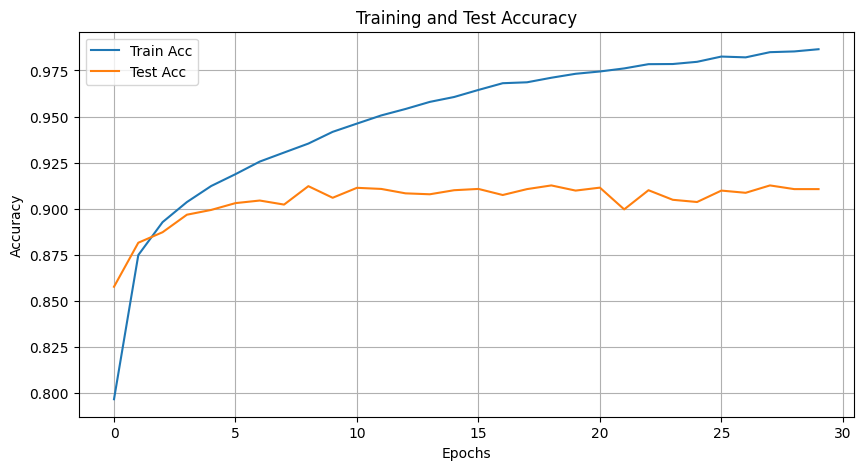

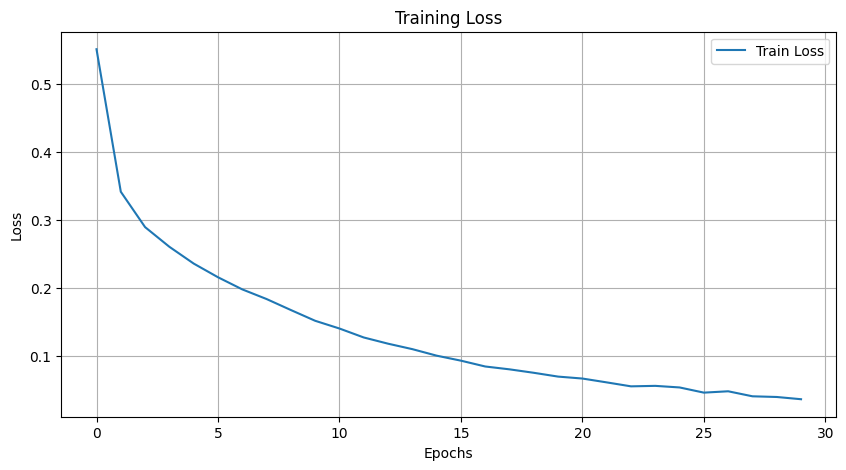

In [ ]:
# Plotting the training and test accuracies
plt.figure(figsize=(10, 5))
plt.title("Training and Test Accuracy")
plt.plot(train_acc_relu_2, label='Train Acc')
plt.plot(test_acc_relu_2, label='Test Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.title("Training Loss")
plt.plot(train_loss_relu_2, label='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# A function to evaluate the two models performance
def evaluate_model(net, test_loader):
    net.eval()
    all_labels = []
    all_predictions = []
    # Disable gradient computation
    with torch.no_grad():
        # Iterate over test data
        for data in test_loader:
            # Move data to device
            images, labels = data[0].to(device), data[1].to(device)
            # Get model outputs
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            # Append actual and predicted labels for evaluation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    # Calculate precision, recall, and F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    return precision, recall, f1_score

# Evaluate models
precision1, recall1, f1_score1 = evaluate_model(net, test_loader)
precision2, recall2, f1_score2 = evaluate_model(net2, test_loader)

print(f"Model 1 - Precision: {precision1}, Recall: {recall1}, F1 Score: {f1_score1}")
print(f"Model 2 - Precision: {precision2}, Recall: {recall2}, F1 Score: {f1_score2}")


Model 1 - Precision: 0.911292364223724, Recall: 0.9094, F1 Score: 0.9099683196040532
Model 2 - Precision: 0.9115740802509649, Recall: 0.9106, F1 Score: 0.9108336005357194
